# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import string
import time
import os
import pickle
import tqdm
import io

pd.set_option("display.max_colwidth", None)

from wordcloud import WordCloud
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_roc_curve

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from keras.models import Sequential
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping

from IPython.display import Markdown

def bold(string):
    display(Markdown("**" + string + "**"))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [2]:
df_ = pd.read_csv("spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df = df_.copy()
df.columns = ["label", "text"]
df = df[["text", "label"]]
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0


In [3]:
def df_stats(data):
    bold(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLS: {}".format(data.shape[1]))
    bold(" TYPES ".center(50, "#"))
    print(data.dtypes)
    bold(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    bold(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    #bold(" DESCRIBE ".center(50, "#"))
    #print(data.describe().T)
    bold(" MEMORY USAGE ".center(50, "#"))
    buf = io.StringIO()
    data.info(buf=buf)
    info = buf.getvalue().split("\n")[-2].split(":")[1].strip()
    print("Memory Usage: {}".format(info))

In [4]:
df_stats(df)

**##################### SHAPE ######################**

ROWS: 5572
COLS: 2


**##################### TYPES ######################**

text     object
label     int64
dtype: object


**################# MISSING VALUES #################**

text     0
label    0
dtype: int64


**############### DUPLICATED VALUES ################**

NUMBER OF DUPLICATED VALUES: 403


**################## MEMORY USAGE ##################**

Memory Usage: 87.2+ KB


In [5]:
df = df.drop_duplicates()

# Exploratory Data Analysis

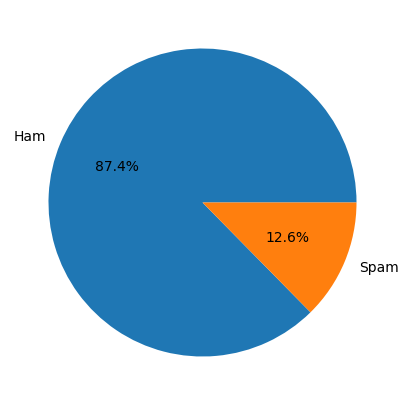

In [6]:
total_0, total_1 = len(df[df["label"] == 0]), len(df[df["label"] == 1])
label = np.array(["Ham", "Spam"])
values = np.array([total_0, total_1])
plt.figure(figsize=(5, 5))
plt.pie(values, labels=label, autopct="%.1f%%")
plt.show()

In [7]:
def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

In [8]:
nltk.download('punkt')


[nltk_data] Error loading punkt: <urlopen error [Errno 2] No such file
[nltk_data]     or directory>


False

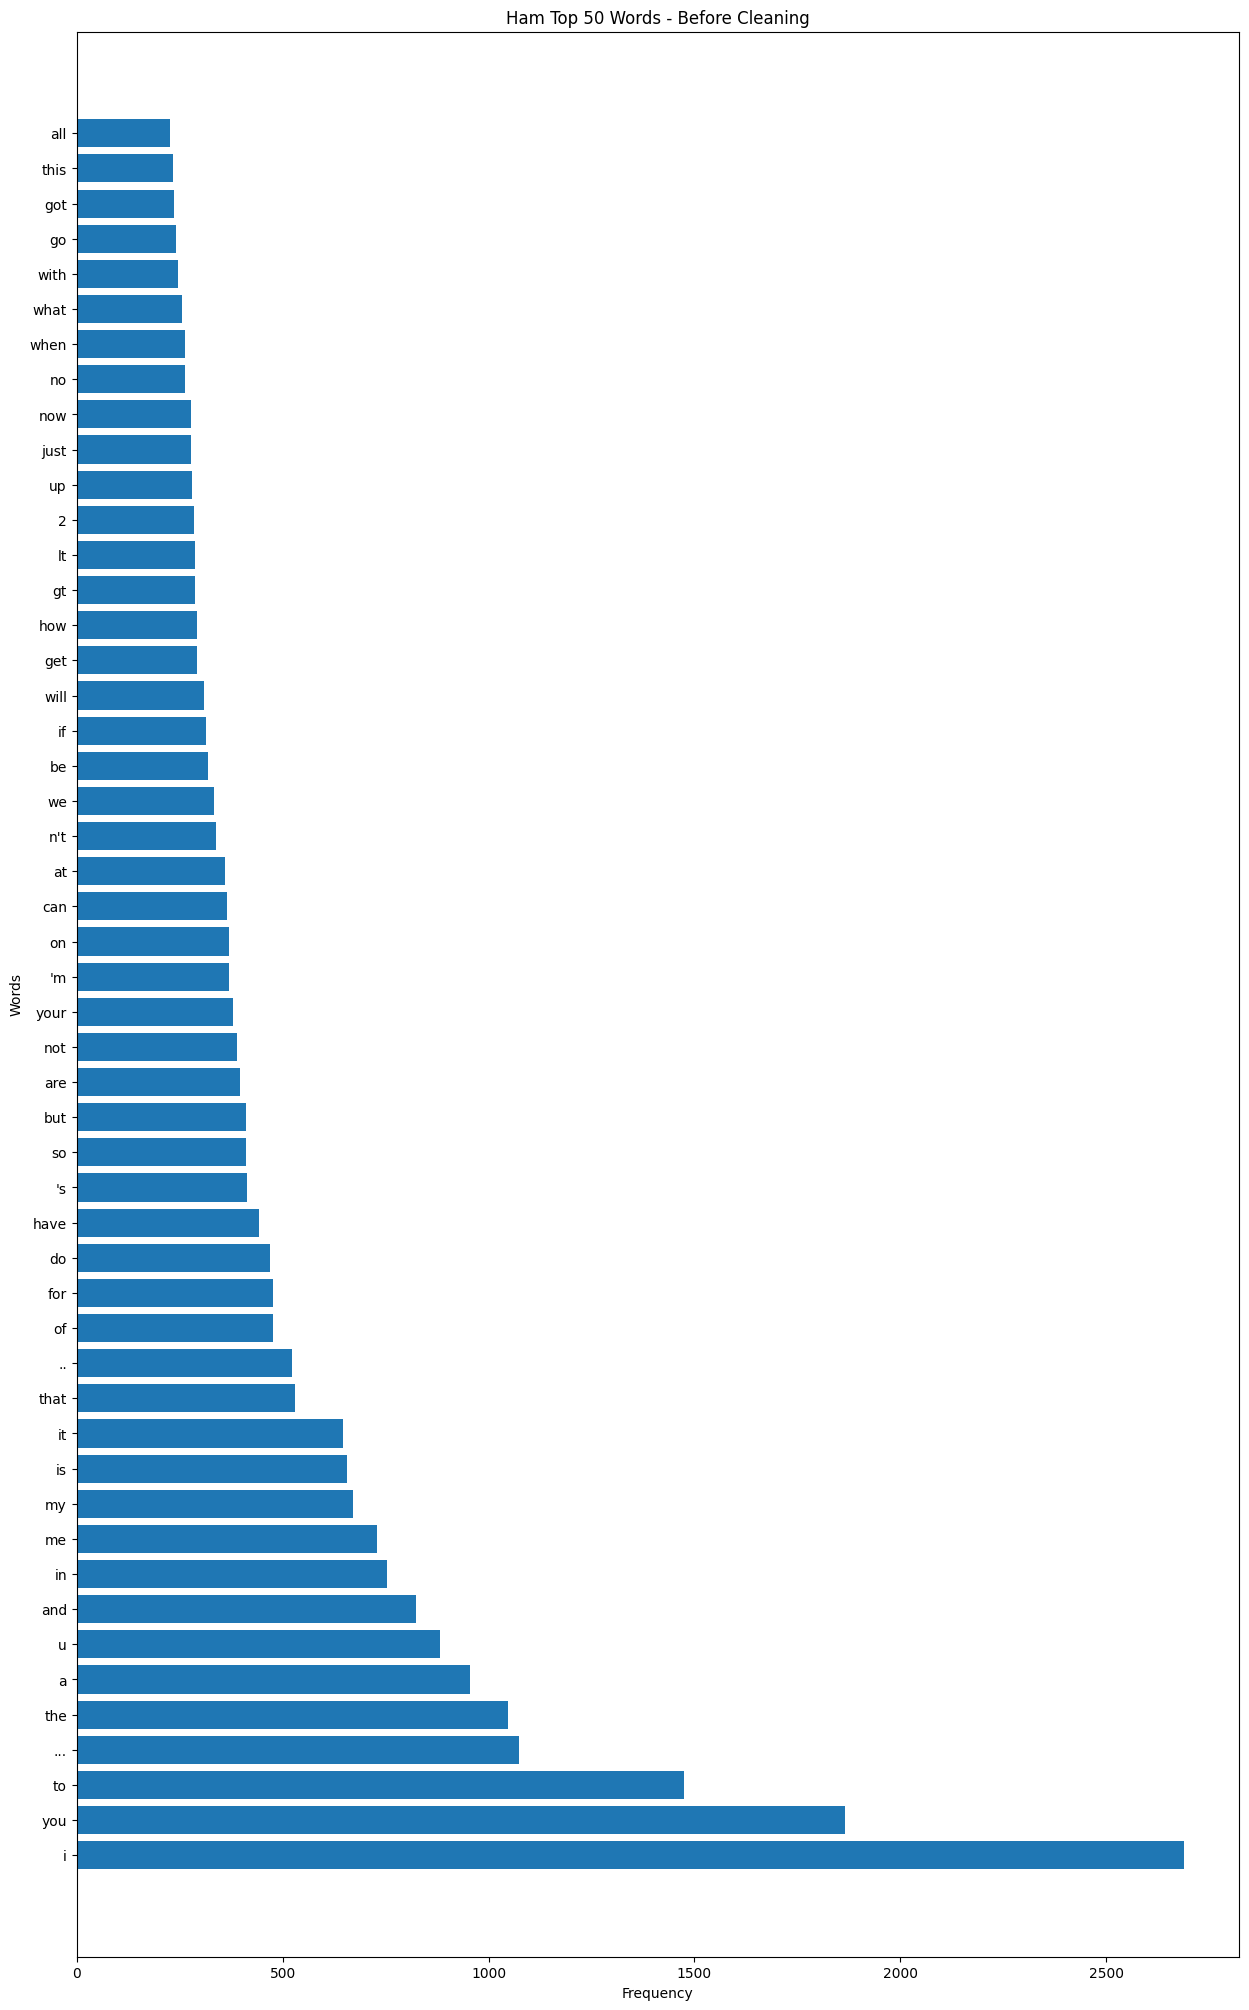

In [9]:

ham_freq_top = word_freq(df, 0, "text", "Ham Top 50 Words - Before Cleaning")

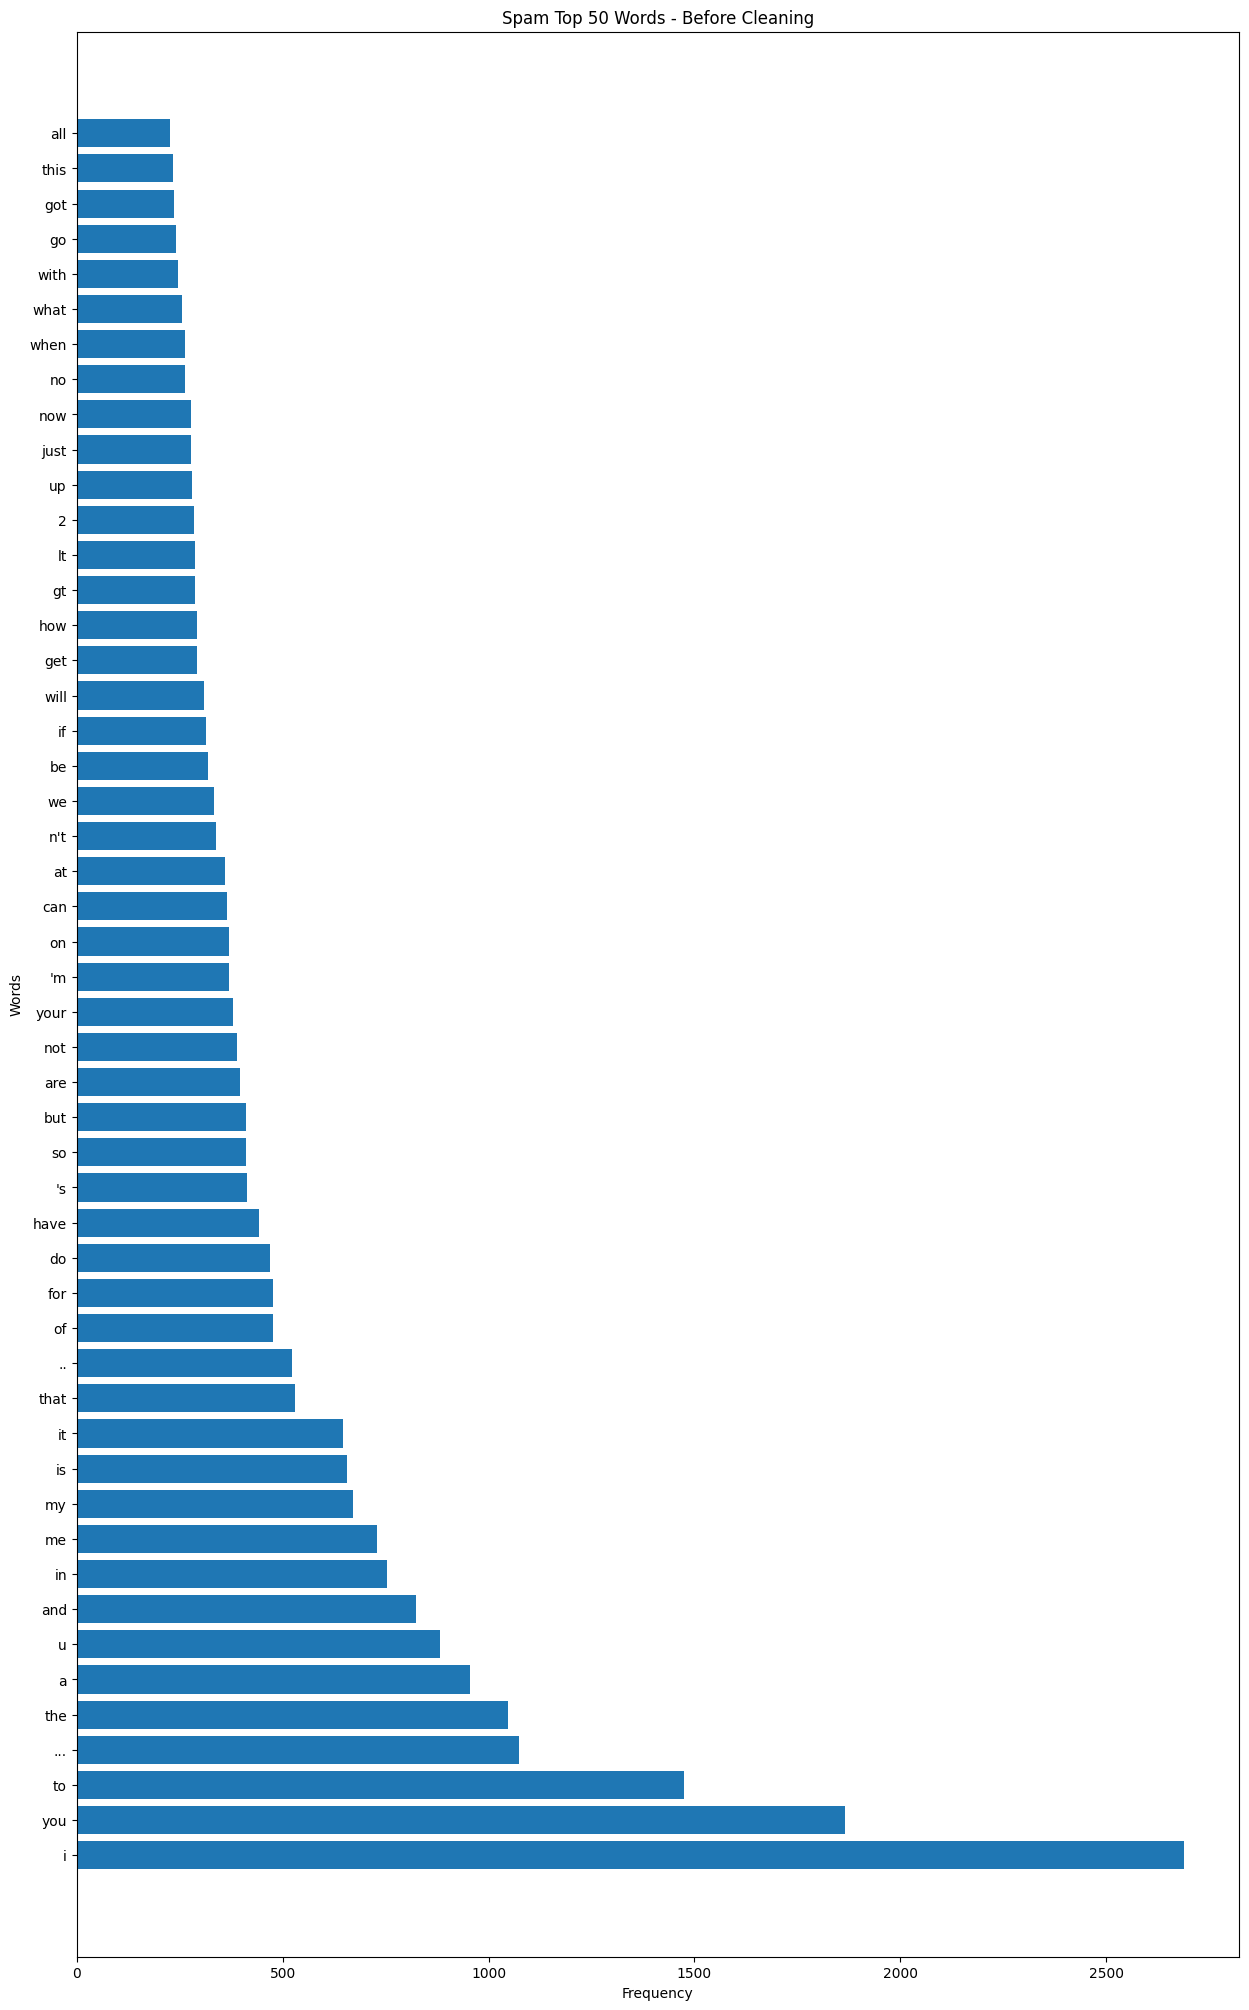

In [10]:
spam_freq_top = word_freq(df, 0, "text", "Spam Top 50 Words - Before Cleaning")

In [11]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

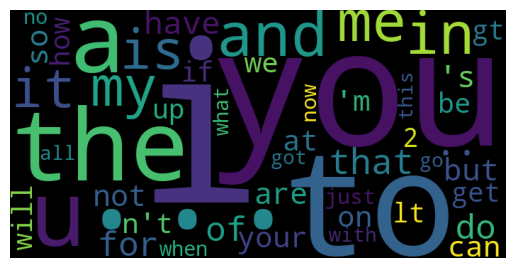

In [12]:
print_wordcloud(ham_freq_top)

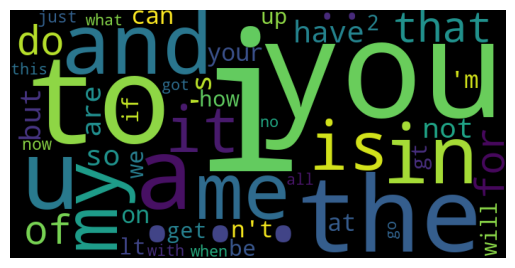

In [13]:
print_wordcloud(spam_freq_top)

# Preprocess

In [14]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>


False

In [15]:
stop_words = set(stopwords.words("english"))

In [16]:
smart_words = "SmartStoplist.txt"
print(smart_words)

SmartStoplist.txt


In [17]:
smart_stoplist = []

In [18]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [19]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [20]:
smart_stoplist.append("_")

In [21]:
#!ls -l /usr/share/nltk_data/

In [22]:
nltk.download("all")
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
# ! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = " ".join([word for word in text.split() if word not in smart_stoplist])
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

[nltk_data] Error loading all: <urlopen error [Errno 2] No such file
[nltk_data]     or directory>
[nltk_data] Error loading stopwords: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>
[nltk_data] Error loading wordnet: <urlopen error [Errno 2] No such
[nltk_data]     file or directory>


In [23]:
df["clean"] = df["text"].apply(clean)

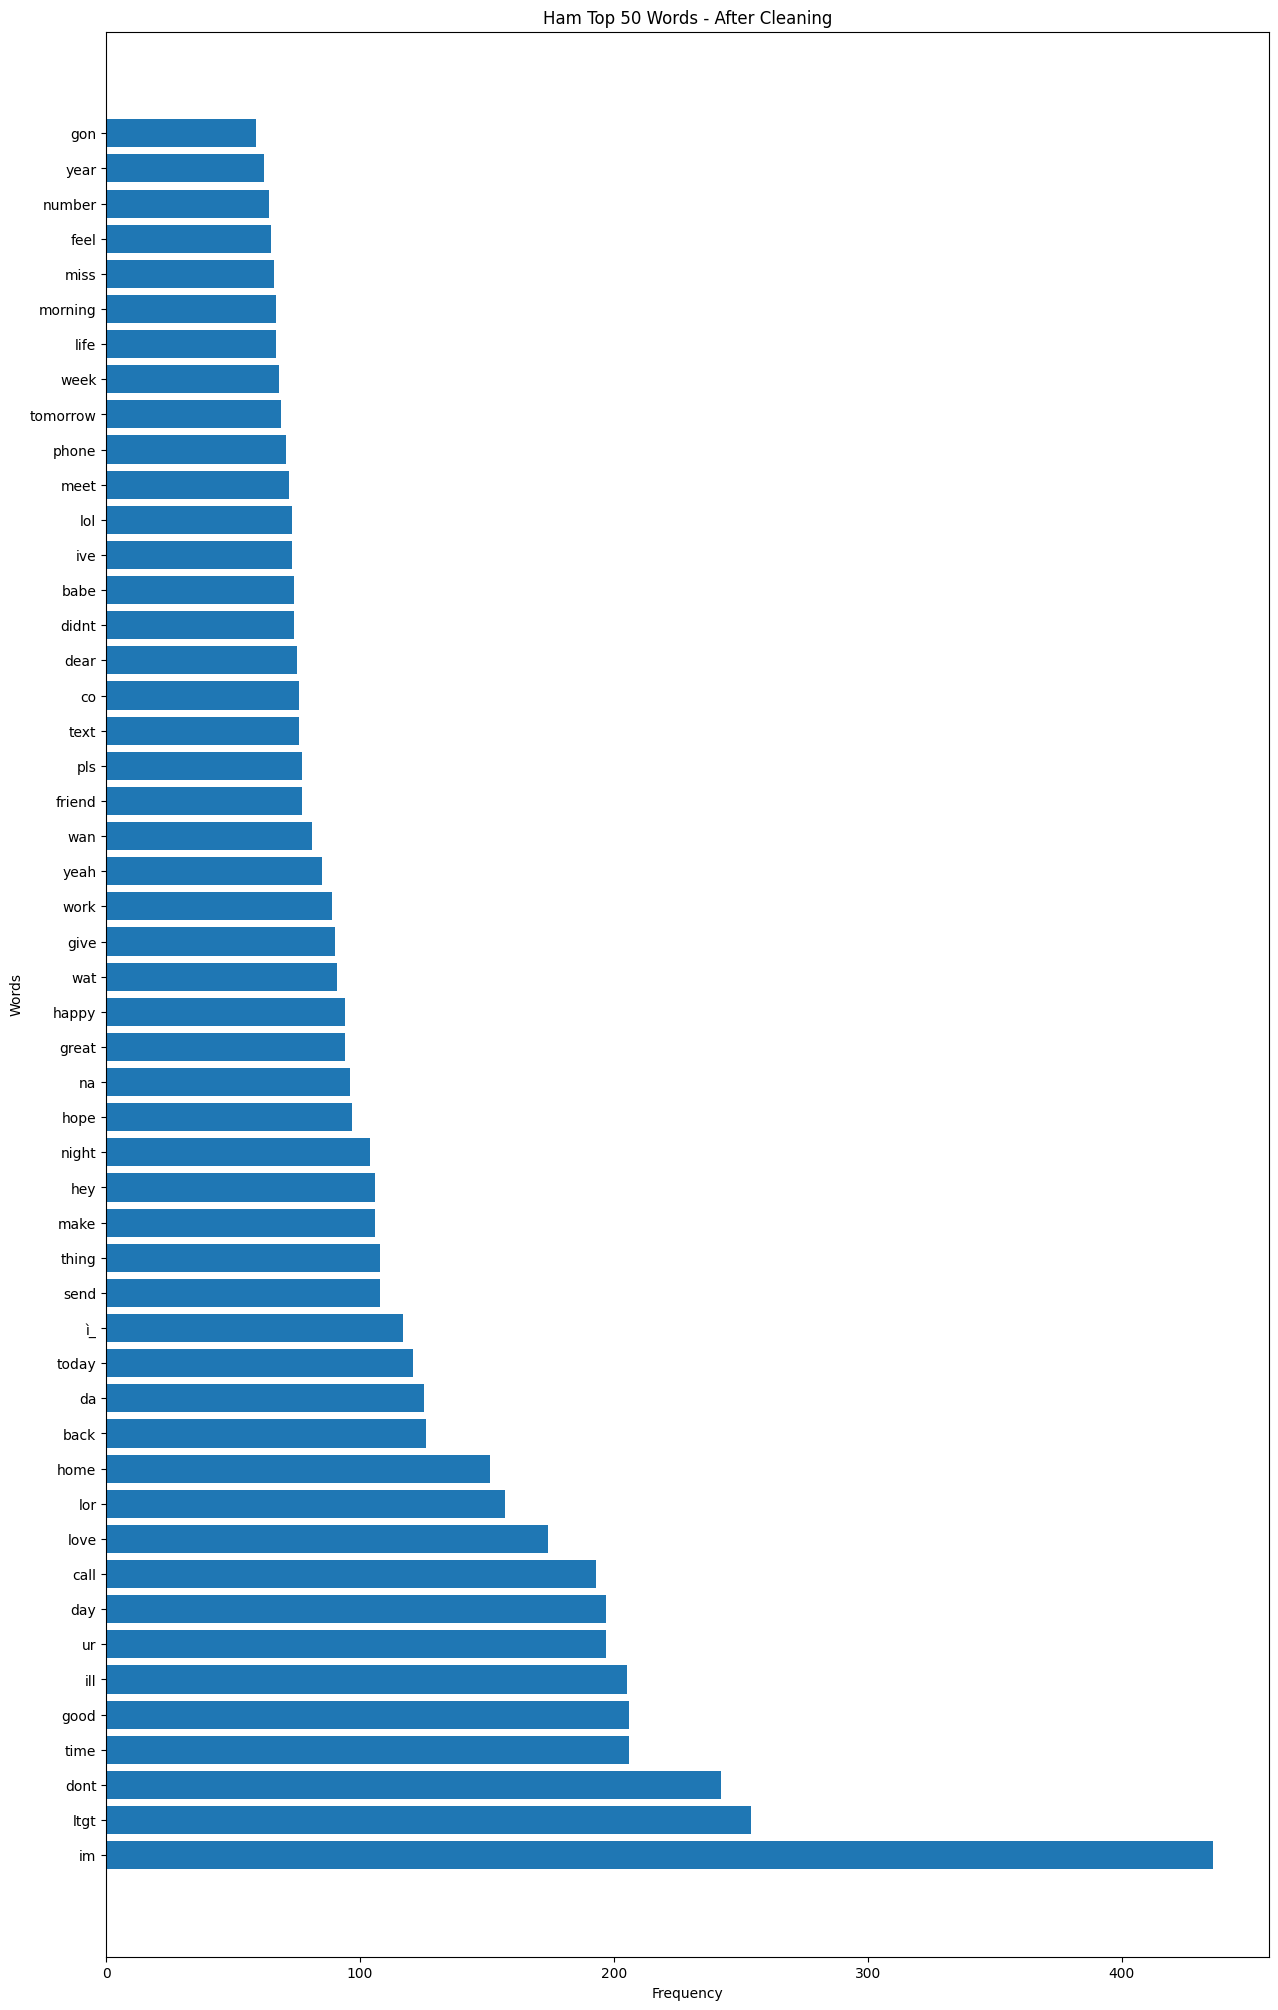

In [24]:
clean_ham_freq_top = word_freq(df, 0, "clean", "Ham Top 50 Words - After Cleaning")

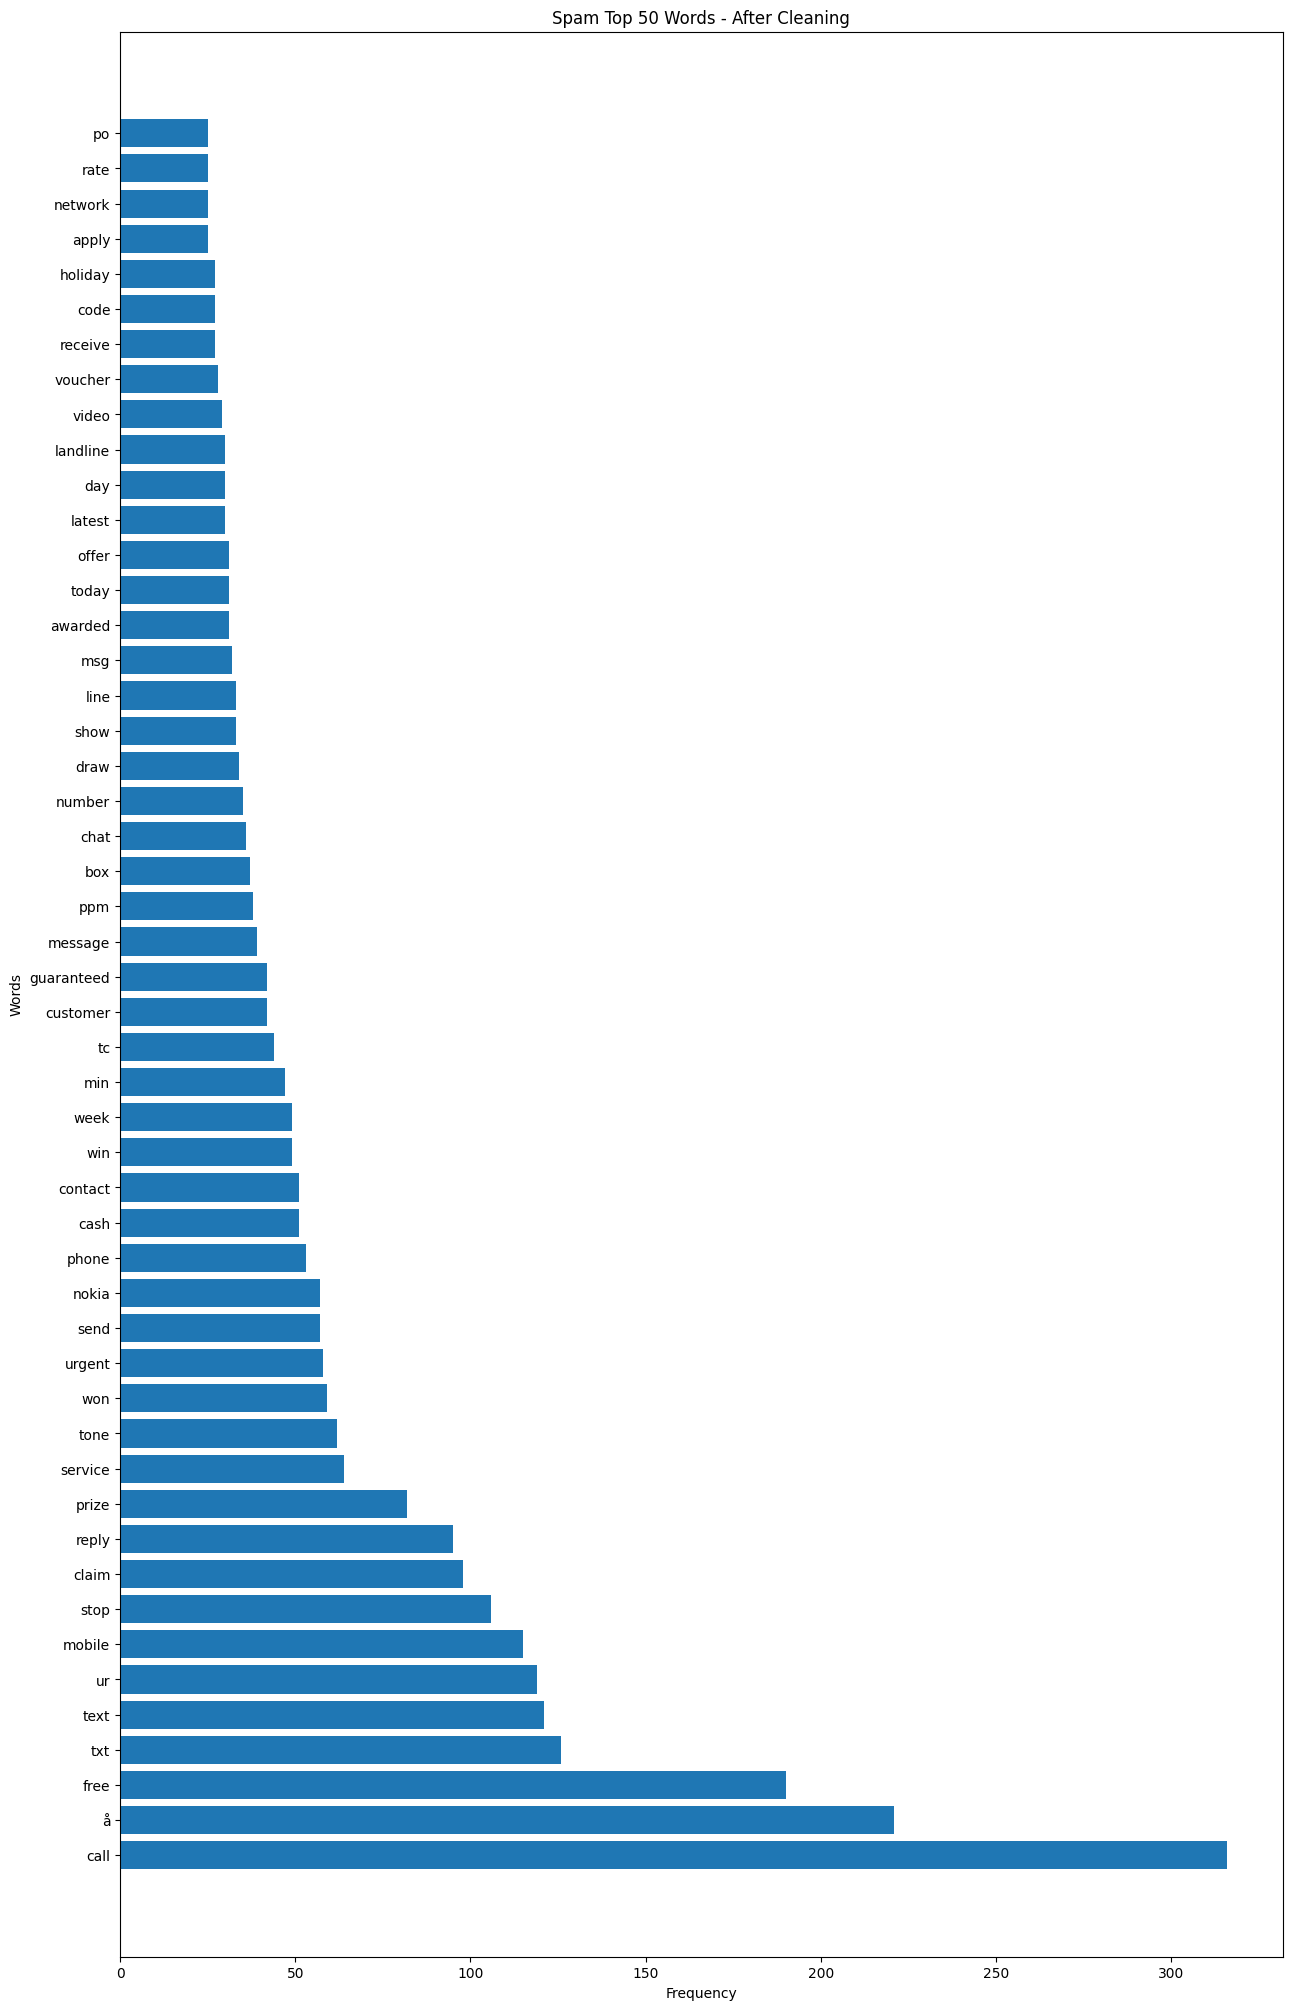

In [25]:
clean_spam_freq_top = word_freq(df, 1, "clean", "Spam Top 50 Words - After Cleaning")

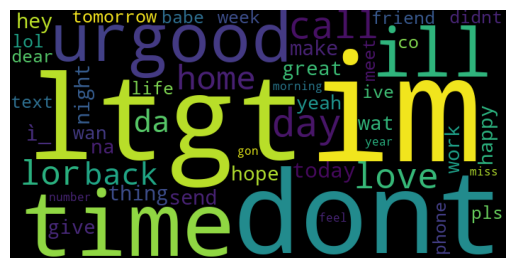

In [26]:
print_wordcloud(clean_ham_freq_top)

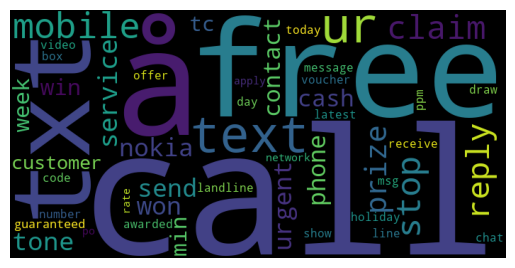

In [27]:
print_wordcloud(clean_spam_freq_top)

# Feature Scaling

In [28]:
X = df["clean"]
y = df["label"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [32]:
maxlen = 70

In [33]:
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [34]:
word_index = tokenizer.word_index
len(word_index)

7643

In [35]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [36]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [37]:
embeddings_index = {}
f = open("glove.840B.300d.txt", "r", encoding="utf-8")
for line in tqdm.tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs

f.close()
print("Found %s word vectors." % len(embeddings_index))

2196018it [03:26, 10615.53it/s]

Found 2196017 word vectors.


In [38]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████████| 7643/7643 [00:01<00:00, 5527.08it/s]


# TFIDF + MultinomialNB

In [39]:
mnb = MultinomialNB()
mnb_tfidf_train_start = time.time()
mnb.fit(X_train_tfidf, y_train)
mnb_tfidf_train_end = time.time()
mnb_tfidf_train_time = mnb_tfidf_train_end - mnb_tfidf_train_start
print("TFIDF + MultnomialNB Train Time = ", mnb_tfidf_train_time)

TFIDF + MultnomialNB Train Time =  0.08937573432922363


In [40]:
mnb_tfidf_pred_train = mnb.predict(X_train_tfidf)
mnb_tfidf_test_start = time.time()
mnb_tfidf_pred_test = mnb.predict(X_test_tfidf)
mnb_tfidf_test_end = time.time()
mnb_tfidf_test_time = mnb_tfidf_test_end - mnb_tfidf_test_start

mnb_tfidf_train_score = accuracy_score(mnb_tfidf_pred_train, y_train)
mnb_tfidf_test_score = accuracy_score(mnb_tfidf_pred_test, y_test)
print(f"TFIDF + MultinomialNB Train Score = {mnb_tfidf_train_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Score = {mnb_tfidf_test_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Test Time = ", mnb_tfidf_test_time)

TFIDF + MultinomialNB Train Score = 97.07%
TFIDF + MultinomialNB Test Score = 95.84%
TFIDF + MultinomialNB Test Time =  0.0010082721710205078


In [41]:
mnb_tfidf_precision_score = precision_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_f1_score = f1_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_recall_score = recall_score(y_test, mnb_tfidf_pred_test)
mnb_tfidf_accuracy_score = accuracy_score(y_test, mnb_tfidf_pred_test)

print(f"TFIDF + MultinomialNB Precision Score = {mnb_tfidf_precision_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB F1 Score = {mnb_tfidf_f1_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Recall Score = {mnb_tfidf_recall_score * 100:.2f}%")
print(f"TFIDF + MultinomialNB Accuracy Score = {mnb_tfidf_accuracy_score * 100:.2f}%")

TFIDF + MultinomialNB Precision Score = 100.00%
TFIDF + MultinomialNB F1 Score = 82.59%
TFIDF + MultinomialNB Recall Score = 70.34%
TFIDF + MultinomialNB Accuracy Score = 95.84%


In [42]:
print(classification_report(y_test, mnb_tfidf_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       889
        spam       1.00      0.70      0.83       145

    accuracy                           0.96      1034
   macro avg       0.98      0.85      0.90      1034
weighted avg       0.96      0.96      0.96      1034



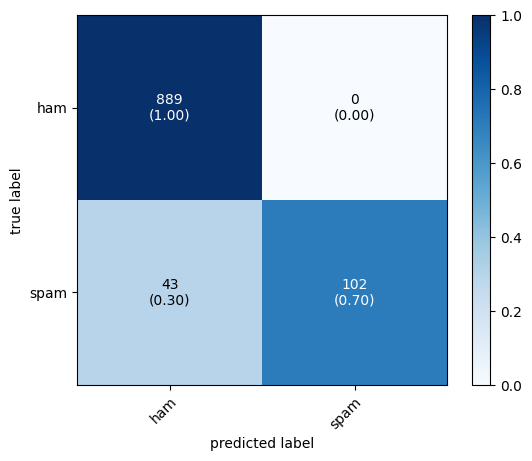

In [43]:
mnb_tfidf_cm = confusion_matrix(y_test, mnb_tfidf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_tfidf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

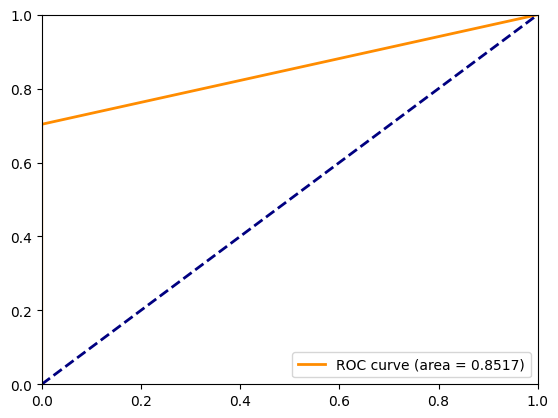

In [44]:
fpr, tpr, _ = roc_curve(y_test, mnb_tfidf_pred_test)
mnb_tfidf_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_tfidf_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# CV + MultinomialNB

In [45]:
mnb = MultinomialNB()
mnb_cv_train_start = time.time()
mnb.fit(X_train_cv, y_train)
mnb_cv_train_end = time.time()
mnb_cv_train_time = mnb_cv_train_end - mnb_cv_train_start
print("CV + MultinomialNB Train Time = ", mnb_cv_train_time)

CV + MultinomialNB Train Time =  0.004500627517700195


In [46]:
mnb_cv_pred_train = mnb.predict(X_train_cv)
mnb_cv_test_start = time.time()
mnb_cv_pred_test = mnb.predict(X_test_cv)
mnb_cv_test_end = time.time()
mnb_cv_test_time = mnb_cv_test_end - mnb_cv_test_start

mnb_cv_train_score = accuracy_score(mnb_cv_pred_train, y_train)
mnb_cv_test_score = accuracy_score(mnb_cv_pred_test, y_test)
print(f"CV + MultinomialNB Train Score = {mnb_cv_train_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Score = {mnb_cv_test_score * 100:.2f}%")
print(f"CV + MultinomialNB Test Time = ", mnb_cv_test_time)

CV + MultinomialNB Train Score = 98.96%
CV + MultinomialNB Test Score = 97.68%
CV + MultinomialNB Test Time =  0.002000093460083008


In [47]:
mnb_cv_precision_score = precision_score(y_test, mnb_cv_pred_test)
mnb_cv_f1_score = f1_score(y_test, mnb_cv_pred_test)
mnb_cv_recall_score = recall_score(y_test, mnb_cv_pred_test)
mnb_cv_accuracy_score = accuracy_score(y_test, mnb_cv_pred_test)

print(f"CV + MultinomialNB Precision Score = {mnb_cv_precision_score * 100:.2f}%")
print(f"CV + MultinomialNB F1 Score = {mnb_cv_f1_score * 100:.2f}%")
print(f"CV + MultinomialNB Recall Score = {mnb_cv_recall_score * 100:.2f}%")
print(f"CV + MultinomialNB Accuracy Score = {mnb_cv_accuracy_score * 100:.2f}%")

CV + MultinomialNB Precision Score = 94.16%
CV + MultinomialNB F1 Score = 91.49%
CV + MultinomialNB Recall Score = 88.97%
CV + MultinomialNB Accuracy Score = 97.68%


In [48]:
print(classification_report(y_test, mnb_cv_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.94      0.89      0.91       145

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



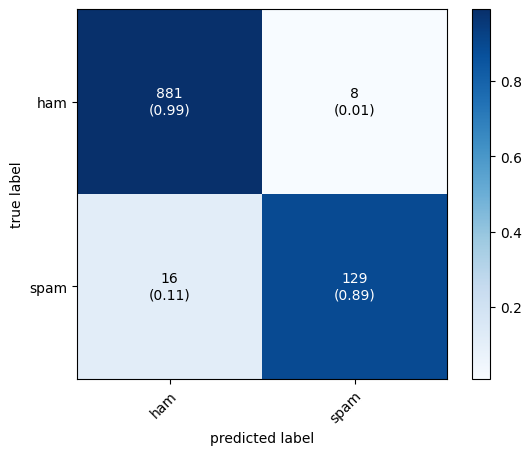

In [49]:
mnb_cv_cm = confusion_matrix(y_test, mnb_cv_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=mnb_cv_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

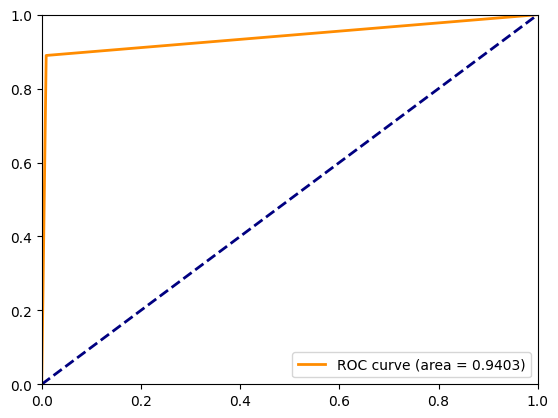

In [50]:
fpr, tpr, _ = roc_curve(y_test, mnb_cv_pred_test)
mnb_cv_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {mnb_cv_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# SimpleRNN

In [51]:
simplernn = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])

simplernn.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])    

simplernn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 32)            244608    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               13300     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 258009 (1007.85 KB)
Trainable params: 258009 (1007.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/5
59/59 [==============================] - 2s 21ms/step - loss: 0.3684 - accuracy: 0.8683 - val_loss: 0.2141 - val_accuracy: 0.9130
Epoch 2/5
59/59 [==============================] - 1s 17ms/step - loss: 0.1207 - accuracy: 0.9629 - val_loss: 0.0643 - val_accuracy: 0.9807
Epoch 3/5
59/59 [==============================] - 1s 17ms/step - loss: 0.0458 - accuracy: 0.9884 - val_loss: 0.0457 - val_accuracy: 0.9831
Epoch 4/5
59/59 [==============================] - 1s 17ms/step - loss: 0.0292 - accuracy: 0.9925 - val_loss: 0.1178 - val_accuracy: 0.9662
Epoch 5/5
59/59 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.9949 - val_loss: 0.0632 - val_accuracy: 0.9831
Model1 Train Time =  6.598327159881592


In [53]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 [==============================] - 0s 5ms/step
Model1 Test Time =  0.44289398193359375


In [54]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 [==============================] - 1s 5ms/step
SimpleRNN Train Score = 99.40%
SimpleRNN Test Score = 97.87%


In [55]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 100.00%
SimpleRNN F1 Score = 91.79%
SimpleRNN Recall Score = 84.83%
SimpleRNN Accuracy Score = 97.87%


In [56]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       1.00      0.85      0.92       145

    accuracy                           0.98      1034
   macro avg       0.99      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034



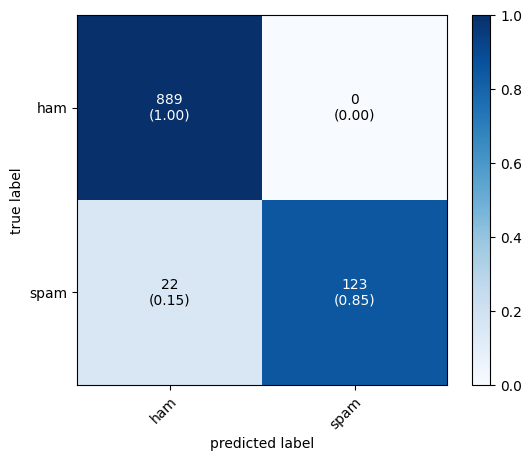

In [57]:
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

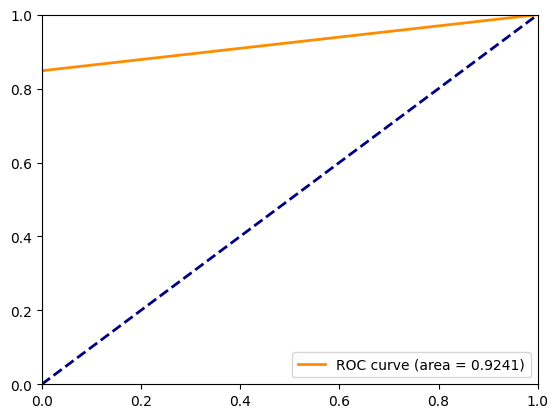

In [58]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {simplernn_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# LSTM

In [59]:
lstm = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 32)            244608    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 297909 (1.14 MB)
Trainable params: 297909 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/5
59/59 [==============================] - 6s 58ms/step - loss: 0.3646 - accuracy: 0.8801 - val_loss: 0.1310 - val_accuracy: 0.9541
Epoch 2/5
59/59 [==============================] - 3s 52ms/step - loss: 0.1030 - accuracy: 0.9739 - val_loss: 0.0441 - val_accuracy: 0.9879
Epoch 3/5
59/59 [==============================] - 3s 52ms/step - loss: 0.0400 - accuracy: 0.9884 - val_loss: 0.0466 - val_accuracy: 0.9855
Epoch 4/5
59/59 [==============================] - 3s 51ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0616 - val_accuracy: 0.9686
Epoch 5/5
59/59 [==============================] - 3s 51ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0553 - val_accuracy: 0.9807
Model2 Train Time =  17.87714171409607


In [61]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 [==============================] - 1s 14ms/step
Model2 Test Time =  0.8755753040313721


In [62]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 [==============================] - 2s 13ms/step
LSTM Train Score = 99.47%
LSTM Test Score = 97.97%


In [63]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 97.69%
LSTM F1 Score = 92.36%
LSTM Recall Score = 87.59%
LSTM Accuracy Score = 97.97%


In [64]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       0.98      0.88      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



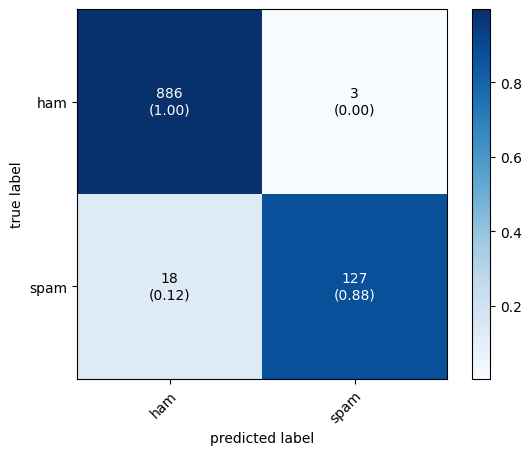

In [65]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

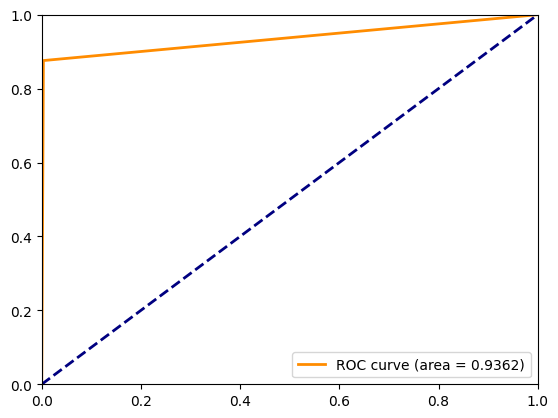

In [66]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# GRU

In [67]:
gru = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    GRU(100),
    Dense(1, activation='sigmoid')
])

gru.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 70, 32)            244608    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 284909 (1.09 MB)
Trainable params: 284909 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/5
59/59 [==============================] - 5s 55ms/step - loss: 0.3758 - accuracy: 0.8686 - val_loss: 0.1480 - val_accuracy: 0.9324
Epoch 2/5
59/59 [==============================] - 3s 48ms/step - loss: 0.0967 - accuracy: 0.9704 - val_loss: 0.0478 - val_accuracy: 0.9783
Epoch 3/5
59/59 [==============================] - 3s 47ms/step - loss: 0.0359 - accuracy: 0.9898 - val_loss: 0.0620 - val_accuracy: 0.9758
Epoch 4/5
59/59 [==============================] - 3s 49ms/step - loss: 0.0191 - accuracy: 0.9952 - val_loss: 0.0534 - val_accuracy: 0.9734
Epoch 5/5
59/59 [==============================] - 3s 53ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.0612 - val_accuracy: 0.9710
Model3 Train Time =  17.065505981445312


In [69]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

33/33 [==============================] - 1s 11ms/step
Model3 Test Time =  0.786961555480957


In [70]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

130/130 [==============================] - 1s 11ms/step
GRU Train Score = 99.64%
GRU Test Score = 97.68%


In [71]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 92.31%
GRU F1 Score = 91.67%
GRU Recall Score = 91.03%
GRU Accuracy Score = 97.68%


In [72]:
print(classification_report(y_test, gru_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       889
        spam       0.92      0.91      0.92       145

    accuracy                           0.98      1034
   macro avg       0.95      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



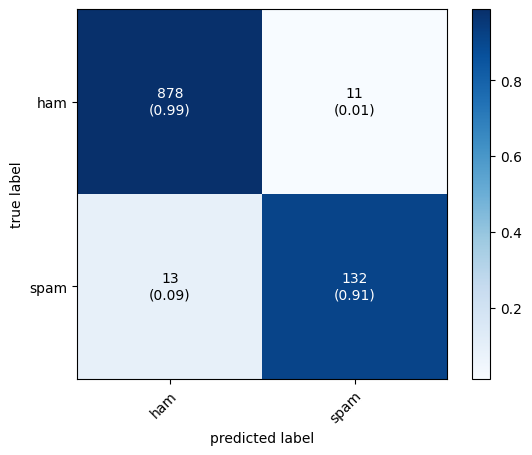

In [73]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

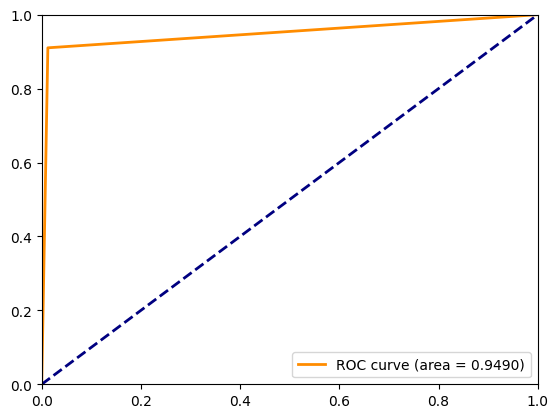

In [74]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Bi-LSTM

In [75]:
bilstm = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    Bidirectional(LSTM(100, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

bilstm.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 70, 32)            244608    
                                                                 
 bidirectional (Bidirection  (None, 70, 200)           106400    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 351209 (1.34 MB)
Trainable params: 351209 (1.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
model4_train_start = time.time()
bilstm_results = bilstm.fit(X_train_tokenizer, y_train, epochs=5, batch_size=64, validation_split=0.1)
model4_train_end = time.time()
model4_train_time = model4_train_end - model4_train_start
print("Model4 Train Time = ", model4_train_time)

Epoch 1/5
59/59 [==============================] - 10s 110ms/step - loss: 0.4190 - accuracy: 0.8732 - val_loss: 0.2935 - val_accuracy: 0.9130
Epoch 2/5
59/59 [==============================] - 5s 91ms/step - loss: 0.2711 - accuracy: 0.9054 - val_loss: 0.1211 - val_accuracy: 0.9686
Epoch 3/5
59/59 [==============================] - 5s 91ms/step - loss: 0.0865 - accuracy: 0.9801 - val_loss: 0.0766 - val_accuracy: 0.9807
Epoch 4/5
59/59 [==============================] - 5s 90ms/step - loss: 0.0464 - accuracy: 0.9868 - val_loss: 0.0769 - val_accuracy: 0.9734
Epoch 5/5
59/59 [==============================] - 5s 92ms/step - loss: 0.0242 - accuracy: 0.9936 - val_loss: 0.0941 - val_accuracy: 0.9662
Model4 Train Time =  31.94701600074768


In [77]:
model4_test_start = time.time()
bilstm_pred_test = bilstm.predict(X_test_tokenizer)
model4_test_end = time.time()
model4_test_time = model4_test_end - model4_test_start
print("Model4 Test Time = ", model4_test_time)

33/33 [==============================] - 1s 20ms/step
Model4 Test Time =  1.3918795585632324


In [78]:
bilstm_pred_train = bilstm.predict(X_train_tokenizer)
bilstm_pred_train = [1 if i > 0.5 else 0 for i in bilstm_pred_train]
bilstm_pred_test = [1 if i > 0.5 else 0 for i in bilstm_pred_test]
bilstm_train_score = accuracy_score(bilstm_pred_train, y_train)
bilstm_test_score = accuracy_score(bilstm_pred_test, y_test)
print(f"BILSTM Train Score = {bilstm_train_score * 100:.2f}%")
print(f"BILSTM Test Score = {bilstm_test_score * 100:.2f}%")

130/130 [==============================] - 3s 20ms/step
BILSTM Train Score = 99.25%
BILSTM Test Score = 96.13%


In [79]:
bilstm_precision_score = precision_score(y_test, bilstm_pred_test)
bilstm_f1_score = f1_score(y_test, bilstm_pred_test)
bilstm_recall_score = recall_score(y_test, bilstm_pred_test)
bilstm_accuracy_score = accuracy_score(y_test, bilstm_pred_test)

print(f"BILSTM Precision Score = {bilstm_precision_score * 100:.2f}%")
print(f"BILSTM F1 Score = {bilstm_f1_score * 100:.2f}%")
print(f"BILSTM Recall Score = {bilstm_recall_score * 100:.2f}%")
print(f"BILSTM Accuracy Score = {bilstm_accuracy_score * 100:.2f}%")

BILSTM Precision Score = 83.02%
BILSTM F1 Score = 86.84%
BILSTM Recall Score = 91.03%
BILSTM Accuracy Score = 96.13%


In [80]:
print(classification_report(y_test, bilstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       889
        spam       0.83      0.91      0.87       145

    accuracy                           0.96      1034
   macro avg       0.91      0.94      0.92      1034
weighted avg       0.96      0.96      0.96      1034



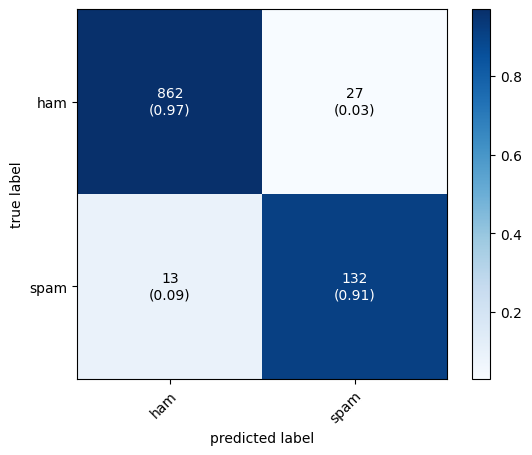

In [81]:
bilstm_cm = confusion_matrix(y_test, bilstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=bilstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

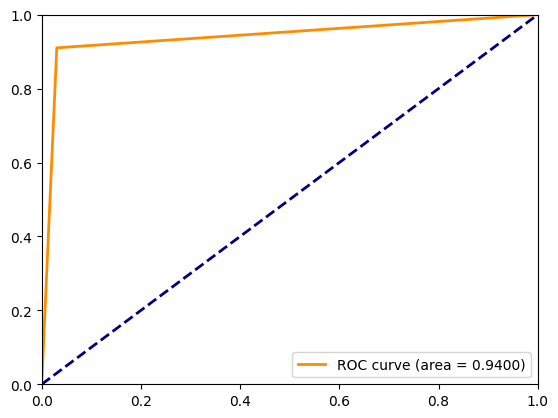

In [82]:
fpr, tpr, _ = roc_curve(y_test, bilstm_pred_test)
bilstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {bilstm_roc_auc :.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

# Results

In [83]:
scores_df = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [84]:
scores_df.loc[0] = ["MultinomialNB + TFIDF",
                    mnb_tfidf_train_time,
                    mnb_tfidf_test_time,
                    mnb_tfidf_train_score,
                    mnb_tfidf_test_score,
                    mnb_tfidf_accuracy_score,
                    mnb_tfidf_f1_score,
                    mnb_tfidf_precision_score,
                    mnb_tfidf_recall_score,
                    mnb_tfidf_roc_auc]

In [85]:
scores_df.loc[1] = ["MultinomialNB + CountVectorizer",
                    mnb_cv_train_time,
                    mnb_cv_test_time,
                    mnb_cv_train_score,
                    mnb_cv_test_score,
                    mnb_cv_accuracy_score,
                    mnb_cv_f1_score,
                    mnb_cv_precision_score,
                    mnb_cv_recall_score,
                    mnb_cv_roc_auc]

In [86]:
scores_df.loc[2] = ["SimpleRNN + GloVe",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [87]:
scores_df.loc[3] = ["LSTM + GloVe",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [88]:
scores_df.loc[4] = ["GRU + GloVe",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [89]:
scores_df.loc[5] = ["Bi-LSTM + GloVe",
                    model4_train_time,
                    model4_test_time,
                    bilstm_train_score,
                    bilstm_test_score,
                    bilstm_accuracy_score,
                    bilstm_f1_score,
                    bilstm_precision_score,
                    bilstm_recall_score,
                    bilstm_roc_auc]

In [90]:
scores_df

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
0,MultinomialNB + TFIDF,0.089376,0.001008,0.970738,0.958414,0.958414,0.825911,1.000000,0.703448,0.851724
1,MultinomialNB + CountVectorizer,0.004501,0.002000,0.989601,0.976789,0.976789,0.914894,0.941606,0.889655,0.940328
2,SimpleRNN + GloVe,6.598327,0.442894,0.993954,0.978723,0.978723,0.917910,1.000000,0.848276,0.924138
3,LSTM + GloVe,17.877142,0.875575,0.994680,0.979691,0.979691,0.923636,0.976923,0.875862,0.936244
4,GRU + GloVe,17.065506,0.786962,0.996372,0.976789,0.976789,0.916667,0.923077,0.910345,0.948986
5,Bi-LSTM + GloVe,31.947016,1.391880,0.992503,0.961315,0.961315,0.868421,0.830189,0.910345,0.939987


In [ ]:
import urllib.request as request
from urllib.error import HTTPError
from http.client import HTTPResponse
from typing import Dict, List, Union
import json
from datetime import datetime
import signal
import os
import threading
signal.signal(signal.SIGINT, signal.SIG_DFL)

print("Telegram Bot is running...")
e = threading.Event()
class TelegramEcho:
    def __init__(self, TG_KEY: str):
        self.TG_URL = "https://api.telegram.org/bot6916731983:AAGJwIwv9_-9Ln7MW0q-62VHSRRvi1POPl8/"
        self.TG_KEY = TG_KEY

        self.__last = None
        self.__last_time = None
        pass
    def predict(input_text):
        result=-1
        mnb_tfidf_pred_test = 1 if mnb.predict(input_text)>0.5 else 0
        mnb_cv_pred_test = 1 if  mnb.predict(input_text)>0.5 else 0
        simplernn_pred_test =1 if  simplernn.predict(input_text)>0.5 else 0
        lstm_pred_test = 1 if lstm.predict(input_text)>0.5 else 0
        gru_pred_test = 1 if gru.predict(input_text)>0.5 else 0
        bilstm_pred_test = 1 if bilstm.predict(input_text)>0.5 else 0

        if ( mnb_tfidf_pred_test+mnb_cv_pred_test+simplernn_pred_test+lstm_pred_test+gru_pred_test+bilstm_pred_test>4):
            result = 1
        else:
            result = 0

        return result
        
    def run(self):
        """
        method to handle the incoming message
        """
        while True:
            try:
                # getting the incoming data
                incoming = self.__handle_incoming()

                # checking if incoming message_id is same as of last, then skip
                if self.__last == incoming["message"]["message_id"]:
                    continue
                else:
                    self.__last = incoming["message"]["message_id"]

                # adding more validation to prevent messaging the last message whenever the polling starts
                if not self.__last_time:
                    self.__last_time = incoming["message"]["date"]
                    continue
                elif self.__last_time < incoming["message"]["date"]:
                    self.__last_time = incoming["message"]["date"]
                else:
                    continue
                    
                outgoing = self.__handle_outgoing(
                    incoming["message"]["chat"]["id"], incoming["message"]["text"]
                )

                pass
            except (HTTPError, IndexError):
                continue
            pass
        pass
    
    def __handle_incoming(self) -> Dict[str, Union[int, str]]:
        """
        method fetch the recent messages
        """

        # getting all messages
        getUpdates = request.urlopen(
            self.TG_URL.format(key=self.TG_KEY, method="getUpdates")
        )

        # parsing results
        results: List[Dict[str, Union[int, str]]] = json.loads(
            getUpdates.read().decode()
        )["result"]

        # getting the last error
        return results[-1]

    def __handle_outgoing(
        self, chat_id: int, message_txt: str
    ) -> Dict[str, Union[int, str]]:
        input_send=Predict(message_txt)
        if input_send == 0:
            input_send = "The Message is classified as not spam"
        if input_send == 1:
            input_send = "The Message is classified as Spam"
        # making the post data
        _data: Dict[str, Union[int, str]] = {
            "chat_id": chat_id,
            "text": input_send,
        }

        # creating the request
        _request: request.Request = request.Request(
            self.TG_URL.format(key=self.TG_KEY, method="sendMessage"),
            data=json.dumps(_data).encode("utf8"),
            headers={"Content-Type": "application/json"},
        )

        # sending HTTP request, for sending message to the user
        sendMessage: HTTPResponse = request.urlopen(_request)
        result: Dict[str, Union[int, str]] = json.loads(sendMessage.read().decode())[
            "result"
        ]
        return result
    pass
e.wait()

Telegram Bot is running...
